In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

import os
import copy

# os.chdir('/content/drive/MyDrive/Colab Notebooks/Shashank')

os.chdir('/Users/shashanksule/Documents/TMDmaps/Twowell')
# Regular Modules
import numpy as np
import sklearn as sklearn
import matplotlib.pyplot as plt
import datetime
import scipy.integrate as scint
#from numpy.random import default_rng
import numpy.ma as ma
import matplotlib.tri as tri
import scipy.io
import time 
from mpl_toolkits.mplot3d import axes3d
# parallelization modules 

from math import nan
from joblib import Parallel, delayed
import multiprocessing
import itertools

# # My Modules
import helpers as helpers
import model_systems as model_systems
import diffusion_map as dmap

# Potential 



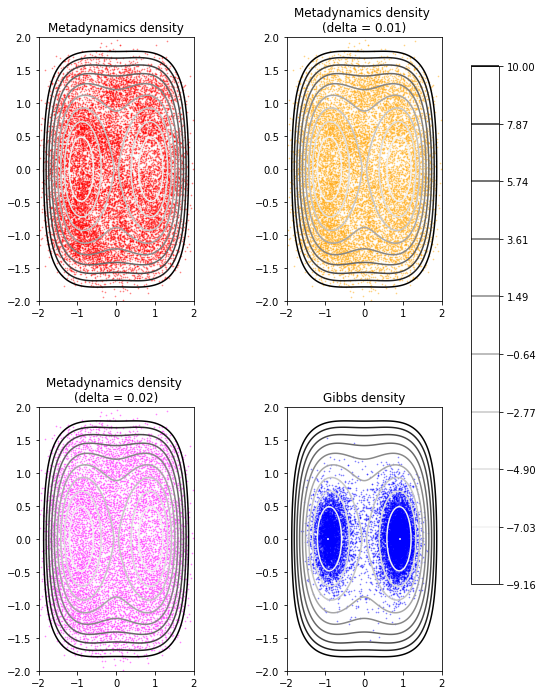

In [3]:
hfont = {'fontname':'Comic Sans MS'}
beta = 1.0; 
inData = scipy.io.loadmat(os.getcwd() + "/ground_data/Twowell_data_metadynamics_longsample_beta_0.66.mat") # to load metadynamics data, use "Muller_Data_FEM20_data20_Metadynamics.mat"
data = inData['samples']
metad_data = data.T
inData = scipy.io.loadmat(os.getcwd() + "/ground_data/Twowell_trajectory_1.5.mat")
data = inData['traj']
gibbs_data = data.T
# Plot potential on a grid
# plt.clf()
xmin, xmax = -2.0, 2.0
ymin, ymax = -2.0, 2.0
nx, ny = 128, 128
volume = (xmax - xmin)*(ymax - ymin)
net_1 = helpers.epsilon_net(metad_data, 0.01)[0]
net_2 = helpers.epsilon_net(metad_data, 0.02)[0]

# Plot potential on a grid
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8,8))
plot_params = [nx, ny, xmin, xmax, ymin, ymax]
[potential_grid, xx, yy] = helpers.gen_plot_data(helpers.twowell_potential, plot_params)
grid_min = np.min(potential_grid)
#print("grid minimum is: %d" % grid_min)
contour_levels = np.linspace(grid_min, 10, 10)
im = ax1.contour(xx, yy, potential_grid, cmap = 'Greys', levels=contour_levels)
ax1.scatter(metad_data[0,:], metad_data[1,:], c = 'red', alpha = 0.4, s=0.5)
ax1.set(title = "Metadynamics density", xlim = (xmin,xmax),ylim = (ymin, ymax))
ax2.contour(xx, yy, potential_grid, cmap = 'Greys', levels=contour_levels)
ax2.scatter(metad_data[0,net_1], metad_data[1,net_1], c = 'orange', alpha = 0.4, s=0.5)
ax2.set(title = "Metadynamics density \n(delta = 0.01)", xlim = (xmin,xmax),ylim = (ymin, ymax))
ax3.contour(xx, yy, potential_grid, cmap = 'Greys', levels=contour_levels)
ax3.scatter(metad_data[0,net_2], metad_data[1,net_2], c = 'magenta', alpha = 0.4, s=0.5)
ax3.set(title = "Metadynamics density \n(delta = 0.02)", xlim = (xmin,xmax),ylim = (ymin, ymax))
ax4.contour(xx, yy, potential_grid, cmap = 'Greys', levels=contour_levels)
ax4.scatter(gibbs_data[0,:], gibbs_data[1,:], c = 'blue', alpha = 0.4, s=0.5)
ax4.set(title = "Gibbs density", xlim = (xmin,xmax),ylim = (ymin, ymax))
#plt.legend()
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.2, 
                    wspace=0.6, 
                    hspace=0.4)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.25, 0.05, 0.9])
fig.colorbar(im, cax=cbar_ax)
# plt.savefig("twowell_sampling.png")
# plt.title("Two-well Potential")

# Error Analysis

In [4]:
# Load error data
os.chdir(os.getcwd() + "/error_data")
err_metad_long_FEM_TMD = np.load("Error_data_metadynamicsbeta_1_FEMpts_twowell.npy")
err_metad_long_TMD_FEM = np.load("Error_data_metadynamicsbeta_1_TMDpts_twowell.npy")
err_FEM_TMD = np.load("Error_data_gibbsbeta_1_FEMpts_twowell.npy")
err_TMD_FEM = np.load("Error_data_gibbsbeta_1_TMDpts_twowell.npy")
err_unif_FEM_TMD = np.load("Error_data_uniformbeta_1_FEMpts_twowell.npy")
err_unif_TMD_FEM = np.load("Error_data_uniformbeta_1_TMDpts_twowell.npy")
k_metad = np.load("kernel_data_metadynamics.npy")
k_gibbs = np.load("kernel_data_gibbs.npy")
k_unif = np.load("kernel_data_uniform.npy")
N_metad = np.load("N_data_metadynamics.npy")
N_unif = np.load("N_data_uniform.npy")
N_gibbs = np.load("N_data_gibbs.npy")

eps_vals = 2.0**np.arange(-18, 4, 0.5)
delta_vals = np.linspace(1e-6, 1e-1, 10)[:4]
# knn_vals = 2**np.arange(10,6,-5)
# knn_vals = np.array([np.int64(N*0.1)])
vbdry_vals = np.arange(1, -50, -60)
num_idx = eps_vals.shape[0]
num_delta = delta_vals.shape[0]
# num_knn = knn_vals.shape[0]
num_vbdry = vbdry_vals.shape[0]

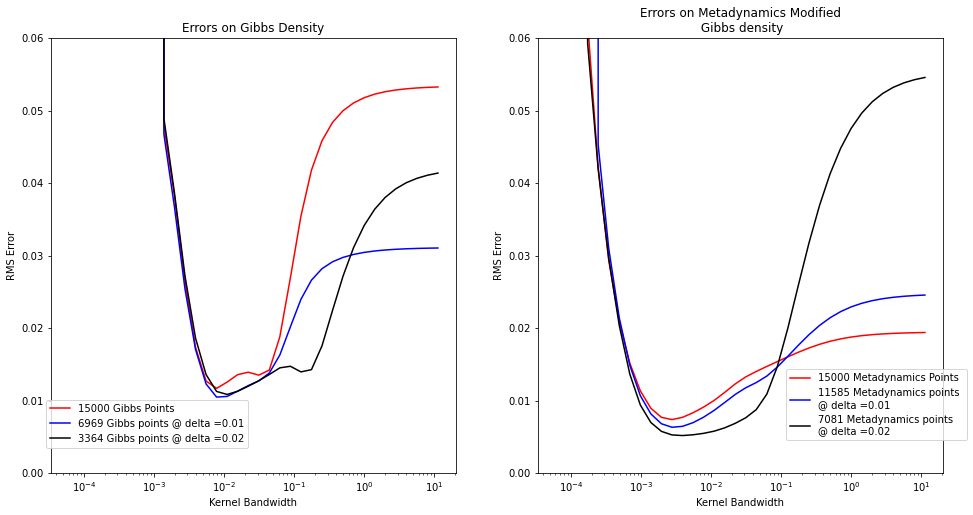

In [8]:
# plot dependence on delta net for gibbs data

# colors_FEM = iter(plt.cm.jet(np.linspace(0,1,num_delta)))
colors_FEM = iter(["Red", "Blue", "Black"])
fig, (ax2, ax3) = plt.subplots(1,2, figsize = (16,8))
ax2.set(xscale = "log")
for i in range(3):
  if i == 0:
    color = next(colors_FEM)
    ax2.plot(eps_vals[1:], err_FEM_TMD[1:, i,-1,-1], 
             # marker = 'o',
             color = color,
             # lw = 2.5,
             label = str(round(N_gibbs[1,i,-1,-1])) + " Gibbs Points")
    # ax2.axvline(x = eps_vals[np.argmax(k_gibbs[:,i,-1,-1])], linestyle = '--', lw = 2.5, alpha = 0.5, color = color)
    k = k_gibbs[:,i,-1,-1]
    n = len(k[(k/max(k)) >= 0.9])
    # ax2.axvline(x = eps_vals[np.argmax(k_gibbs[:,i,-1,-1])], lw = n*10, color = color, alpha=0.1)
  else:
    color = next(colors_FEM)
    ax2.plot(eps_vals[1:], err_FEM_TMD[1:, i,-1,-1], 
             # marker = 'o',
             color = color,
             # lw = 2.5,
             label = str(round(N_gibbs[1,i,-1,-1])) + " Gibbs points @ delta =" + str(round(delta_vals[i],2)))
    # ax2.axvline(x = eps_vals[np.argmax(k_gibbs[:,i,-1,-1])], linestyle = '--', lw = 2.5, alpha = 0.5, color = color)
    k = k_gibbs[:,i,-1,-1]
    n = len(k[(k/max(k)) >= 0.9])
    # ax2.axvline(x = eps_vals[np.argmax(k_gibbs[:,i,-1,-1])], lw = n*10, color = color, alpha=0.1)
ax2.legend(bbox_to_anchor=(0.50, 0.18))
ax2.set(ylim = (0.0,0.06), title = "Errors on Gibbs Density", ylabel = "RMS Error", xlabel = "Kernel Bandwidth");

# plot dependence on delta net for metadynamics data
# colors_FEM = iter(plt.cm.jet(np.linspace(0,1,num_delta)))
colors_FEM = iter(["Red", "Blue", "Black"])
ax3.set(xscale = "log")
for i in range(3):
  if i == 0:
    color = next(colors_FEM)
    ax3.plot(eps_vals[1:], err_metad_long_FEM_TMD[1:, i,-1,-1], 
             # marker = 'o',
             color = color,
             # lw = 2.5,
             label = str(round(N_metad[1,i,-1,-1])) + " Metadynamics Points")
    # ax3.axvline(x = eps_vals[np.argmax(k_metad[:,0,-1,-1])], linestyle = '-.', lw = 2.5, alpha=0.5, color = color)
    k = k_metad[:,i,-1,-1]
    n = len(k[(k/max(k)) >= 0.9])
    # ax3.axvline(x = eps_vals[np.argmax(k_metad[:,i,-1,-1])], lw = n*10, color = color, alpha=0.1)
  else:
    color = next(colors_FEM)
    ax3.plot(eps_vals[1:], err_metad_long_FEM_TMD[1:, i,-1,-1], 
             # marker = 'o',
             color = color,
             # lw = 2.5,
             label = str(round(N_metad[1,i,-1,-1])) + " Metadynamics points \n@ delta =" + str(round(delta_vals[i],2)))
    # ax3.axvline(x = eps_vals[np.argmax(k_metad[:,i,-1,-1])], linestyle = '--', alpha = 0.5, lw = 2.5, color = color)
    k = k_metad[:,i,-1,-1]
    n = len(k[(k/max(k)) >= 0.9])
    # ax3.axvline(x = eps_vals[np.argmax(k_metad[:,i,-1,-1])], lw = n*10, color = color, alpha=0.1)
ax3.legend(bbox_to_anchor=(0.60, 0.25))
ax3.set(ylim = (0.0,0.06), title = "Errors on Metadynamics Modified\n Gibbs density", ylabel = "RMS Error", xlabel = "Kernel Bandwidth");



[(0.0, 0.01)]

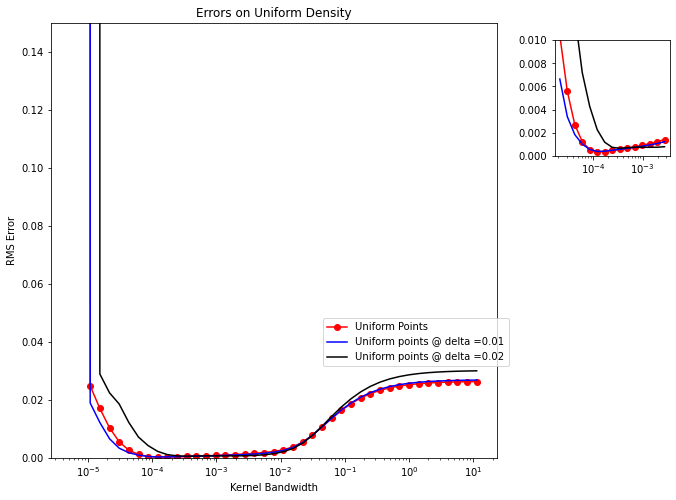

In [10]:
# # plot dependence on delta net for gibbs data
# colors_FEM = iter(plt.cm.viridis(np.linspace(0,1,num_delta)))
# colors_FEM = iter(["Red", "Blue", "Black"])
# fig, ax2 = plt.subplots(figsize = (8,8))
# ax2.set(xscale = "log")
# for i in range(3):
#   if i == 0:
#     color = next(colors_FEM)
#     ax2.plot(eps_vals[1:], err_unif_FEM_TMD[1:, i,-1,-1], 
#              # marker = 'o',
#              color = color,
#              label = "Uniform Points")
#     ax2.axvline(x = eps_vals[np.argmax(k_unif[1:,i,-1,-1])], linestyle = '--', color = color)
#   else:
#     color = next(colors_FEM)
#     ax2.plot(eps_vals[1:], err_unif_FEM_TMD[1:, i,-1,-1], 
#              # marker = 'o',
#              color = color,
#              label = "Uniform points @ delta =" + str(round(delta_vals[i],2)))
#     ax2.axvline(x = eps_vals[np.argmax(k_unif[1:,i,-1,-1])], linestyle = '--', color = color)
# ax2.legend(bbox_to_anchor=(0.60, 0.2))
# ax2.set(ylim = (0.0,0.06), title = "Errors on Uniform Density", ylabel = "RMS Error", xlabel = "Log Kernel Bandwidth");

# plot dependence on delta net for gibbs data
colors_FEM = iter(plt.cm.jet(np.linspace(0,1,3)))
colors_FEM = iter(["Red", "Blue", "Black"])
fig, ax2 = plt.subplots(figsize = (8,8))
ax2.set(xscale = "log")
for i in range(3):
  if i == 0:
    color = next(colors_FEM)
    ax2.plot(eps_vals[1:], err_unif_FEM_TMD[1:, i,-1,-1], 
             marker = 'o',
             color = color,
             label = "Uniform Points")
    # ax2.axvline(x = eps_vals[np.argmax(k_unif[1:,i,-1,-1])], linestyle = '--', lw = 2.5, alpha = 0.5, color = color)
    k = k_unif[:,i,-1,-1]
    n = len(k[(k/max(k)) >= 0.9])
    # ax2.axvline(x = eps_vals[np.argmax(k_unif[:,i,-1,-1])], lw = n*10, color = color, alpha=0.1)
  else:
    color = next(colors_FEM)
    ax2.plot(eps_vals[1:], err_unif_FEM_TMD[1:, i,-1,-1], 
             # marker = 'o',
             color = color,
             label = "Uniform points @ delta =" + str(round(delta_vals[i],2)))
    # ax2.axvline(x = eps_vals[np.argmax(k_unif[1:,i,-1,-1])], linestyle = '--', lw = 2.5, alpha=0.5, color = color)
    k = k_unif[:,i,-1,-1]
    n = len(k[(k/max(k)) >= 0.9])
    # ax2.axvline(x = eps_vals[np.argmax(k_unif[:,i,-1,-1])], lw = n*10, color = color, alpha=0.1)
ax2.legend(bbox_to_anchor=(0.60, 0.2))
ax2.set(ylim = (0.0,0.15), title = "Errors on Uniform Density", ylabel = "RMS Error", xlabel = "Kernel Bandwidth");
colors_FEM = iter(["Red", "Blue", "Black"])
a = plt.axes([1.0, .65, .2, .2], facecolor='w')
a.set(xscale = "log")
for i in range(3):
  if i == 0:
    color = next(colors_FEM)
    a.plot(eps_vals[5:20], err_unif_FEM_TMD[5:20, i,-1,-1], 
             marker = 'o',
             color = color,
             label = "Uniform Points")
    # a.axvline(x = eps_vals[np.argmax(k_unif[1:,i,-1,-1])], linestyle = '--', lw = 2.5, alpha = 0.5, color = color)
  else:
    color = next(colors_FEM)
    a.plot(eps_vals[5:20], err_unif_FEM_TMD[5:20, i,-1,-1], 
             # marker = 'o',
             color = color,
             label = "Uniform points @ delta =" + str(round(delta_vals[i],2)))
    # a.axvline(x = eps_vals[np.argmax(k_unif[1:,i,-1,-1])], linestyle = '--', lw = 2.5, alpha=0.5, color = color)
# ax2.set_facecolor('tab:gray')
a.set(ylim = (0.0,0.01))
# plt.xticks([])
# plt.yticks([])

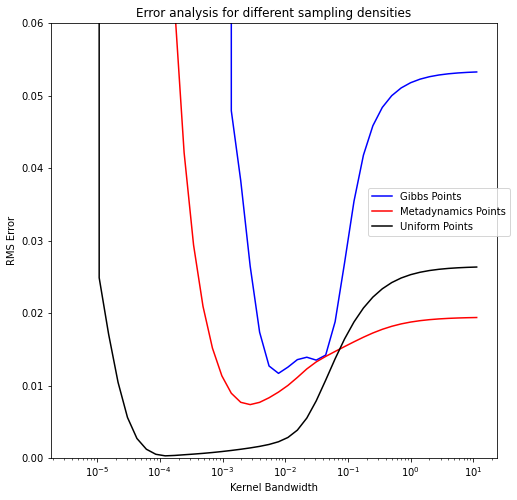

In [11]:
colors_FEM = iter(plt.cm.jet(np.linspace(0,1,3)))
fig, ax2 = plt.subplots(figsize = (8,8))
ax2.set(xscale = "log")
i=0
color = next(colors_FEM),
ax2.plot(eps_vals[:], err_FEM_TMD[:, i,-1,-1], 
         # marker = 'o',
         color = 'Blue',
         label = "Gibbs Points")
# ax2.axvline(x = eps_vals[np.argmax(k_gibbs[:,i,-1,-1])], linestyle = '--', color = 'Blue')
k = k_gibbs[:,i,-1,-1]
n = len(k[(k/max(k)) >= 0.9])
# ax2.axvline(x = eps_vals[np.argmax(k_gibbs[:,i,-1,-1])], lw = n*10, color = 'Blue', alpha=0.1)
color = next(colors_FEM)
ax2.plot(eps_vals[:], err_metad_long_FEM_TMD[:, i,-1,-1], 
         # marker = 'o',
         color = 'Red',
         label = "Metadynamics Points")
# ax2.axvline(x = eps_vals[np.argmax(k_metad[:,i,-1,-1])], linestyle = '--', color = 'Red')
k = k_metad[:,i,-1,-1]
n = len(k[(k/max(k)) >= 0.9])
# ax2.axvline(x = eps_vals[np.argmax(k_metad[:,i,-1,-1])], lw = n*10, color = 'Red', alpha=0.1)
color = next(colors_FEM)
ax2.plot(eps_vals[:], err_unif_FEM_TMD[:, i,-1,-1], 
         # marker = 'o',
         color = 'Black',
         label = "Uniform Points")
# ax2.axvline(x = eps_vals[np.argmax(k_unif[:,i,-1,-1])], linestyle = '--', color = 'Black')
k = k_unif[:,i,-1,-1]
n = len(k[(k/max(k)) >= 0.9])
# ax2.axvline(x = eps_vals[np.argmax(k_unif[:,i,-1,-1])], lw = n*10, color = 'Black', alpha=0.1)
ax2.legend(bbox_to_anchor=(0.70, 0.5))
ax2.set(ylim = (0.0,0.06), title = "Error analysis for different sampling densities", ylabel = "RMS Error", xlabel = "Kernel Bandwidth");